## Introduction
A community is commonly considered as a social unit (a group of people) who share something in common, such as norms, values, identity. For example, if we look at all the users on Facebook, Bill Gates, Steve Jobs, Mark Zuckerberg and other top managers in Silicon Valley companies may form a community because they may share the same interest in technology development.

The concept of community is specifically applied to the analysis of the structure of social networks like Facebook, formulated as graph. In fact, to detect communities in a graph is just to detect group of nodes that connect tightly within other nodes in the same group, while share little thing in common with nodes in different groups.

![introduction](introduction.png)

The figure above illustrates the concept of community detection. Initially we are given a connected graph, this graph will be divided into many different communities (coloured with different colour) after performing community detection.

In this tutorial you will study the basic idea of different community detection algorithms in `networkx` library, as well as utilize them to perform community detection on test graph.

We will cover the following content in this tutorial:

* [Importing graph](#Part-1:-Importing-graph)
* [Visualizing the graph](#Part-2:-Visualizing-the-graph)
* [Community detection algorithms](#Part-3:-Community-detection-algorithms)
* [Extension: Community API](#Extension:-Community-API)

## Libraries

The following libraries are required for this tutorial:

    networkx
    matplotlib

The following are optional:
    
    numpy
    scipy
    pandas
    
We can install the packages using `pip` with just a command in terminal

    > pip install networkx
    
This command will install `networkx` 1.11.

# The test graph

The graph we'll be focusing on for most of this tutorial, is a undirected graph that represents the relationship between a set of users on Facebook. The data is collected with Social Circles (a Facebook web app) by J. McAuley and J. Leskovec. and hosted on [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html). The data is collected by extracting friend lists of 10 Facebook users and aggregate 10 ego networks together by connecting ego networks with Facebook users that appears in multiple networks.

The path of edge file is

    ./facebook_combined.txt
    
an example text of the edge file is (fields delimited by space):
    
    0 1
    0 2
    0 3
    0 4
    0 5

Note that this is actually an undirected graph, so each row "`i j`" represents an undirected edge between node `i` and node `j`, instead of an directed edge from node `i` to node `j`. The user id has been encrypted as integer by the data provider to protect the privacy of Facebook users.

In this tutorial we do not use large data set but there are other larger data set available on [SNAP dataset](https://snap.stanford.edu/data/index.html), some of them like [Youtube](https://snap.stanford.edu/data/com-Youtube.html) also contains the ground-truth communities that can be use for algorithm evaluation.

In [1]:
# Import required library
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import Counter

# Show plots in notebook
% matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Part 1: Importing graph

In this first part of the tutorial, we'll load the graph using `networkx` to create a `networkx.Graph` object.

First we explain some commonly seen data structures in `networkx`.

* Graph

    A data structure that holds nodes and edges, stored in `node` and `adj`.

* Node

    All the nodes are stored in a `networkx.Graph` object as a dictionary where key is the node id and value is the attribute of the node.

* Edge

    All the edges are stored in a `networkx.Graph` object as a adjacency dictionary of dictionay, for example `{0: {1: {'weight':1}}}` represent an edge from node 0 to node 1 having an attribute 'weight' equals 1.

`networkx` provides various functions to create a graph. We can utilize different functions in different cases, for example:
    
* From existing adjacency dictionary of dictionary

In [2]:
dod = {0: {1: {'weight':1} } }
G = nx.from_dict_of_dicts(dod)
print G.edges()

[(0, 1)]


* From existing dictionary of list (key as source and value as list of target)

In [3]:
dol = {0: [1,2,3]}
G = nx.from_dict_of_lists(dol)
print G.edges()

[(0, 1), (0, 2), (0, 3)]


* From numpy matrix (adjacency matrix)

In [15]:
import numpy as np
mat = np.matrix([[0,1],[1,0]])
G = nx.from_numpy_matrix(mat)
print G.edges()

[(0, 1)]


* From scipy sparse matrix (adjacency matrix)

In [16]:
import scipy.sparse as sp
sparse_mat = sp.coo_matrix(([2],([0],[1])), shape=(3,3))
G = nx.from_scipy_sparse_matrix(sparse_mat)
print G.edges()

[(0, 1)]


* From pandas dataframe (list of edges)

In [17]:
import pandas as pd
df = pd.DataFrame([[1,0,4],[1,2,4]], columns=['from', 'to','weight'])
G = nx.from_pandas_dataframe(df, 'from', 'to',['weight'])
print G.edges()

[(0, 1), (1, 2)]


A `networkx.Graph` object can also be transformed back to these supported data types, all we need to do is change the function `from_***` to `to_***`, for example:

In [18]:
df = nx.to_pandas_dataframe(G)
print df

     0    1    2
0  0.0  4.0  0.0
1  4.0  0.0  4.0
2  0.0  4.0  0.0


`networkx` actually provides an easier way to create a `networkx.Graph` object without needing to concern about the type of supported data source (except `pandas.DataFrame` due to an issue  before `networkx-2.0` in the source code https://github.com/networkx/networkx/issues/2111), which calls `networks.convert.to_networkx_graph` function implicitly:

In [19]:
ds = sp.coo_matrix(([1],([0],[1])), shape=(3,3))
G = nx.Graph(ds)
print G.edges()

[(0, 1)]


`networkx` also read/write a `networkx.Graph` object from/to file in several kind of format.

Supported file formats are

* Adjacency List/Multiline Adjacency List
        
* Edge List

* GEXF (Graph Exchange XML Format)

* GML (Graph Modelling Language)

* Pickle

* GraphML

* JSON

* LEDA (A C++ class library format)

* YAML

* SparseGraph6

* Pajek

* GIS Shapefile

We will use `networkx.read_edgelist` to import the graph.

In [2]:
G = nx.Graph()
with open('facebook_combined.txt', 'r') as f:
    nx.read_edgelist(path=f, delimiter=' ', create_using=G, nodetype=int)

We can have a basic information about the network with `nx.info`

In [5]:
print nx.info(G)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


From the output we can figure out that the number of nodes is 4039 and number of edges is 88234. `nx.info` also produces a measure called 'Average degree', which represents then density of a graph in graph theory. A brief introduction to graph theory can be found [here](http://webwhompers.com/graph-theory.html).

## Part 2: Visualizing the graph

Now that we have imported the graph with `networkx`, it is a common practice to try to visualize the graph. Which can give us a understanding of what the graph looks like.

`networkx` plot the graph using `matplotlib` library. To plot a graph, we need to first create a layout.

`networkx` contains various functions for creating layout. For example:

    nx.spring_layout
    nx.spectral_layout
    nx.random_layout
    nx.shell_layout
    nx.nx_pydot.graphviz_layout (pydotplus library required)
    
We will create a 'spring layout', namely a 'fruchterman reingold layout' which forces the graph to be layout in a more readable way.

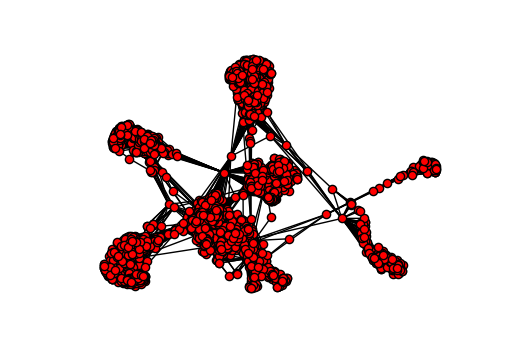

In [22]:
# create layout
layout = nx.spring_layout(G)

# Visualize the graph
plt.axis('off')
nx.draw_networkx(G, arrows = False, pos = layout, with_labels = False, node_size = 35)

## Part 3: Community detection algorithms


### k-clique algorithm

A k-clique is a complete subgraph with k nodes, that is, any pair of nodes in the subgraph are connected. If two k-clique have k-1 common nodes, then these two k-cliques are adjacent. A k-clique community is the largest union of a series of adjacent k-cliques. Because a node can belong to multiple communities, k-clique algorithm is capable of finding overlapping communities.

Note that finding k-cliques and combining them are extremely computational intensive operation. So this function is going to spend much time.

As we know, the Facebook data consists of friend lists of 10 Facebook users. Now we are in a scenario where one of our user wants to figure out communities of his/her friends. Let us do try to figure it out.

There are 6 communities:
frozenset([0, 1, 3, 9, 13, 21, 23, 24, 25, 26, 30, 31, 39, 40, 48, 51, 53, 54, 55, 56, 57, 59, 62, 65, 66, 67, 69, 72, 73, 75, 79, 80, 82, 83, 84, 85, 88, 92, 94, 98])
frozenset([0, 41, 44, 14, 20, 28])
frozenset([0, 89, 6, 95])
frozenset([0, 7, 22, 87])
frozenset([0, 17, 19, 41])
frozenset([0, 16, 82, 29])


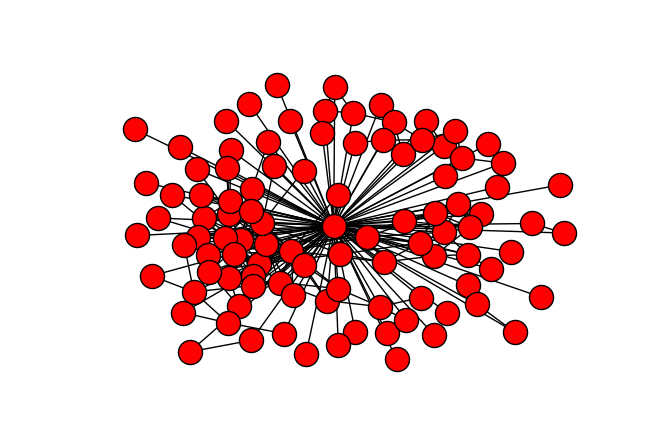

In [20]:
# 0 node is an ego node, let's extract the first 100 nodes as an example
G_sub = G.subgraph(range(100))

# Draw the graph
nx.draw(G_sub)

# find the 4-clique communities
communities = list(nx.k_clique_communities(G_sub, k = 4))
print 'There are %d communities:' % len(communities)
for c in communities:
    print c

As we can see, k-clique algorithm finds six 4-clique communities for us. Of course 'ego' node 0 is an overlapping node, but we can also find the nodes like 82 also belongs to community 0 and community 5. This provide an illustration on what overlapping communities are.

### Label propagation algorithm

Label propagation algorithm is a simple and fast algorithm for community detection. It requires no prior of the structure of the network, that is to say, it can find a reasonable set of communities without parameters. However, because the algorithm involves creating random order of nodes, the algorithm may create unstable results in different runs.

Label propagation algorithm contains the following steps.

1. Initialize the labels at all nodes in the network. For a given node x, C<sub>x</sub> (0) = x.

2. Set t = 1.

3. Arrange the nodes in the network in a random order and set it to X.

4. For each x ∈ X chosen in that specific order, let C<sub>x</sub>(t) = f(C<sub>xi1</sub>(t - 1), ...,C<sub>xim</sub>(t - 1),C<sub>xi(m+1)</sub> (t − 1), ...,C<sub>xik</sub> (t − 1)). f here returns the label occurring with the highest frequency among neighbours.

5. If every node has a label that the maximum number of their neighbours have, then stop the algorithm. Else, set t = t + 1 and go to (3).

As we can see, the iterative algorithm will eventually assign each node a label that is identical to the most common label amongst its neighbours.

Because a node can only be assigned a single label, label propagation algorithm can not find overlapping communities.

In [ ]:
# this only work in the development version of networkx
communities = nx.asyn_lpa_communities(G)
for c in communities:
    print c

Unluckly, label propagation algorithm is not yet available in `networkx` 1.11, which is the latest release version we have. Since it is really simple, Let's implement label propagation algorithm on our own.

In [3]:
"""
LabelProprogation implements a simple label propagation algorithm
"""
class LabelPropagation:
    
    def __init__(self, G):
        self.G = G
        
        # this is the node order
        self.nodes = G.nodes()
        
        # Initialize the labels as a dict
        self.labels = {}
        for i in range(len(self.nodes)):
            self.labels[ self.nodes[i] ] = i
        
    def run(self):
        # iterate until no label change
        while self.iterate():
            pass
        
        # output communities
        communities = {}
        
        for k, v in self.labels.iteritems():
            if v in communities:
                communities[v].append(k)
            else:
                communities[v] = [k]
        
        return communities
        
    def iterate(self):
        shouldContinue = False
        
        # Create a random order
        random.shuffle(self.nodes)
        
        for node in self.nodes:
            # Get all labels of neighbors
            neighbor_labels = [self.labels[n] 
                               for n in self.G.neighbors(node)]
            
            # Get count of labels
            count = Counter(neighbor_labels)
            
            # Find the most common label
            maxcount = 0
            minlabel = 0
            for k, v in count.items():
                if v > maxcount:
                    minlabel = k
                elif v == maxcount and k < minlabel:
                    minlabel = k
                    
            if self.labels[node] != minlabel:
                shouldContinue = True
                self.labels[node] = minlabel
                
        return shouldContinue

In [5]:
G_sub2 = G.subgraph(range(1000))
lpa = LabelPropagation(G_sub2)
communities = lpa.run()
print '%d communities found' % len(communities)

11 communities found


Running our label propagation algorithm, we found 26 communities in our graph. We can visualize the communities. We can run the cell above multiple times and we will find out the the number of communities found varies.

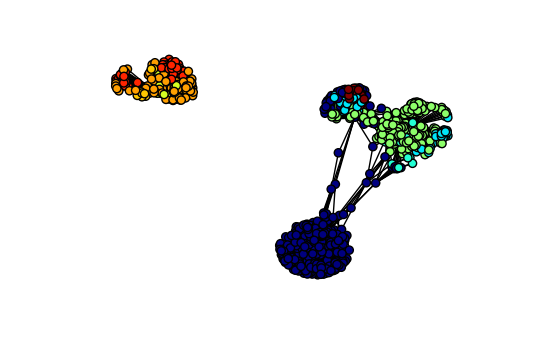

In [9]:
plt.axis('off')
layout2 = nx.spring_layout(G_sub2)
nx.draw_networkx(G_sub2, pos = layout2, 
                 cmap = plt.get_cmap('jet'), 
                 node_color = [lpa.labels[n] for n in G_sub2.nodes()],
                 node_size = 35, with_labels = False)

### Girvan–Newman algorithm

Girvan–Newman algorithm is proposed by Michelle Girvan and Mark Newman. It is a heuristic algorithm for community detection.

Girvan-Newman algorithm focus on the 'betweenness' of edges. 'Betweenness' of edges is defined as the number of shortest path of all pair of nodes that run along this edge. 'Betweenness' of edge represents the pobability that the edge appears between communities. So Girvan-Newman algorithm goes as follows:

1. Compute the betweenness of all edges
2. Remove the edge that has the highest betweenness
3. Recalculate the edges that is affected by the removal
4. Repeat step 2 and 3 until no edge left

Girvan-Newman algorithm preduces node sets at different steps of removal, so communities of different modularity can be detected.

In [ ]:
# this only work in networkx 2.0
communities = nx.girvan_newman(G)
print communities[0]

Unluckily, again, the current release version of `networkx` does not have this algorithm yet. Again we can try to implement a simple Girvan-Newman algorithm.

In [103]:
class GN:
    
    def __init__(self, G):
        self.G = G.copy()
        
    def run(self, level):
        for i in range(level):
            # calculate betweenness
            betweenness = Counter()
            shortest_paths = nx.all_pairs_shortest_path(self.G)
            for dest_dict in shortest_paths.itervalues():
                for path in dest_dict.itervalues():
                    if len(path) > 1:
                        betweenness += Counter(zip(path[:-1], path[1:]))
            
            to_remove = betweenness.most_common(1)[0][0]
            self.G.remove_edge(*to_remove)

In [104]:
gn = GN(G_sub)
gn.run(1)

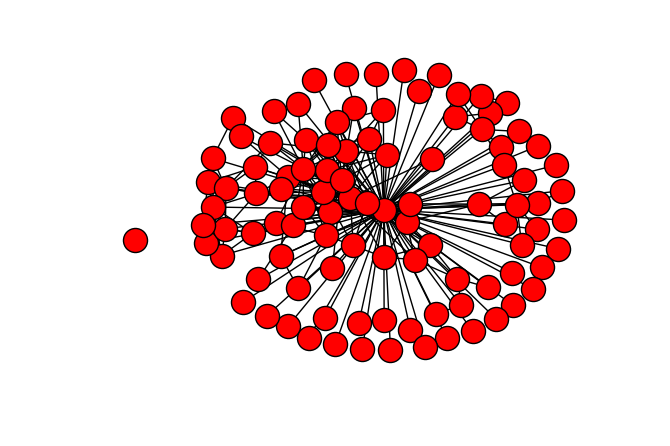

In [105]:
nx.draw(gn.G)

Girven-Newman algorithm basically cuts edges in the graph to increase number of connected components, so it will be the users' choice to choose a modularity of community.

## Extension: Community API

There is also an [community API](https://bitbucket.org/taynaud/python-louvain/overview) built on `networkx`. This API basically implement one recent community detection algorithm - Louvain algorithm.

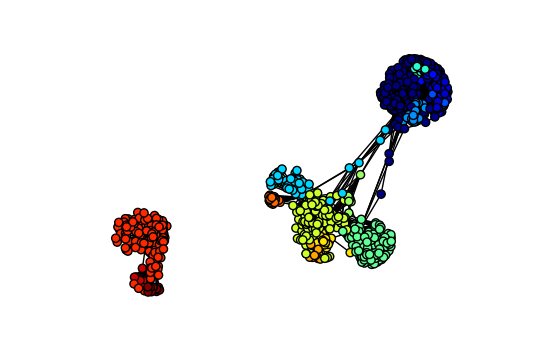

In [6]:
import community

partitions = community.best_partition(G_sub2)

plt.axis('off')
nx.draw_networkx(G_sub2, pos = layout2, 
                 cmap = plt.get_cmap('jet'), 
                 node_color = [partitions.get(n) for n in G_sub2.nodes()],
                 node_size = 35, with_labels = False)